In [5]:
import clip
import numpy as np
import torch
import PIL.Image
import os
from embedding import get_delta_t
from manipulator import Manipulator
from mapper import get_delta_s
from wrapper import Generator

In [2]:
device = torch.device('cuda:2')
ckpt = 'pivot_tuning_inversion/checkpoints/model_PLPLIHFZUBII_multi_id.pt'
G = Generator(ckpt, device)
model, preprocess = clip.load("ViT-B/32", device=device)
fs3 = np.load('tensor/fs3.npy')
expdir = 'pivot_tuning_inversion/test2'
num_images = 1
lst_alpha = [0]

In [3]:
manipulator = Manipulator(G, device, lst_alpha, num_images)

In [9]:
image_names = [imgpath.split('.')[0] for imgpath in os.listdir('pivot_tuning_inversion/aligned2')]
embedding_dir = 'pivot_tuning_inversion/embeddings/test/e4e/'

In [13]:
ws = list()
for image_name in image_names:
    w = torch.load(embedding_dir+f'{image_name}/0.pt')
    ws.append(w)
ws = torch.cat(ws).to(device)

In [14]:
#manipulator.set_real_img_projection(expdir, mode='w')
manipulator.latent = ws
manipulator.num_images = ws.shape[0]
manipulator.styles = G.mapping_stylespace(ws)
#manipulator

In [135]:
lst_alpha = [-3, 0]
manipulator.set_alpha(lst_alpha)

# --------------------------------------

#classnames=['neutral face', 'face with smile']
classnames=['face with eyes', 'face with big eyes']
beta_threshold = 0.20
delta_t = get_delta_t(classnames, model)
delta_s, num_channel = get_delta_s(fs3, delta_t, manipulator, beta_threshold=beta_threshold)
print(f'{num_channel} channels will be manipulated under the beta threshold {beta_threshold}')

25 channels will be manipulated under the beta threshold 0.2


In [136]:
styles = manipulator.manipulate(delta_s)

In [137]:
all_imgs = manipulator.synthesis_from_styles(styles, 0, manipulator.num_images)

In [138]:
lst = []
for imgs in all_imgs:
    lst.append((imgs.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).numpy())

-3


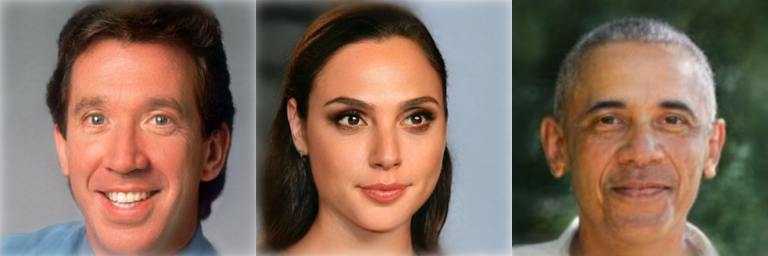

0


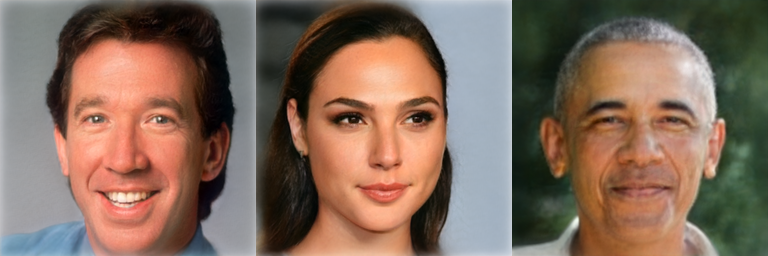

In [139]:
H,W = (256,256)
gw, gh = (manipulator.num_images, 1)

for i, alpha in enumerate(lst_alpha):
    print(alpha)
    imgs = lst[i]
    imgs_ = []    
    for img in imgs:
        imgs_.append( np.asarray( PIL.Image.fromarray(img, 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    imgs_ = np.stack(imgs_)
    imgs_ = imgs_.reshape(gh,gw,H,W,3)
    imgs_ = imgs_.transpose(0,2,1,3,4)
    imgs_ = imgs_.reshape(gh*H, gw*W, 3)
    display(PIL.Image.fromarray(imgs_, 'RGB'))